In [99]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from numpy import array
from keras.preprocessing.text import one_hot
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers import Concatenate
import re
import matplotlib.pyplot as plt

In [100]:
df = pd.read_csv("datasets/categorizer_cleaned.csv")
df

,Unnamed: 0,cleaned,hate_speech,cyberbullying
0,0,dalits lowlives,1,0
1,1,gay people burden society,1,0
2,2,arabs welcome,1,0
3,3,say actually eliminate heebs wish naturally be...,1,0
4,4,bananas black people,1,0
...,...,...,...,...
101703,101703,vandaliser sajidfairooz israeliregime would ra...,1,0
101704,101704,toallahwereturn one christ terror group longer...,1,0
101705,101705,dankmtl peacenothate asshole israelis defend,1,0
101706,101706,since islam believe people leave religion murd...,1,0


In [101]:
# removing the unnamed extra index column that was formed during the construction of the dataset
df.drop(df.filter(regex="Unname"),axis=1, inplace=True)

In [102]:
df

,cleaned,hate_speech,cyberbullying
0,dalits lowlives,1,0
1,gay people burden society,1,0
2,arabs welcome,1,0
3,say actually eliminate heebs wish naturally be...,1,0
4,bananas black people,1,0
...,...,...,...
101703,vandaliser sajidfairooz israeliregime would ra...,1,0
101704,toallahwereturn one christ terror group longer...,1,0
101705,dankmtl peacenothate asshole israelis defend,1,0
101706,since islam believe people leave religion murd...,1,0


In [103]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', str(sen))

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [104]:
labels = df[["hate_speech", "cyberbullying"]]
X = []
sentences = list(df["cleaned"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = labels.values

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

We need to convert text inputs into embedded vectors.

In [106]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [107]:
# We will be using GloVe word embeddings to convert text inputs to their numeric counterparts.

from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [108]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(2, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [109]:
print(model.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 200, 100)          5222300   
                                                                 
 lstm_5 (LSTM)               (None, 128)               117248    
                                                                 
 dense_6 (Dense)             (None, 2)                 258       
                                                                 
Total params: 5,339,806
Trainable params: 117,506
Non-trainable params: 5,222,300
_________________________________________________________________
None


In [110]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [111]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
509/509 [==============================] - 186s 362ms/step - loss: 0.6865 - acc: 0.5481 - val_loss: 0.6849 - val_acc: 0.5556
Epoch 2/10
509/509 [==============================] - 292s 574ms/step - loss: 0.6854 - acc: 0.5495 - val_loss: 0.6844 - val_acc: 0.5569
Epoch 3/10
509/509 [==============================] - 288s 565ms/step - loss: 0.6027 - acc: 0.6477 - val_loss: 0.4560 - val_acc: 0.7996
Epoch 4/10
509/509 [==============================] - 288s 565ms/step - loss: 0.4232 - acc: 0.8111 - val_loss: 0.4070 - val_acc: 0.8175
Epoch 5/10
509/509 [==============================] - 294s 579ms/step - loss: 0.3927 - acc: 0.8250 - val_loss: 0.3902 - val_acc: 0.8289
Epoch 6/10
509/509 [==============================] - 299s 587ms/step - loss: 0.3718 - acc: 0.8348 - val_loss: 0.3890 - val_acc: 0.8258
Epoch 7/10
509/509 [==============================] - 294s 578ms/step - loss: 0.3576 - acc: 0.8409 - val_loss: 0.3723 - val_acc: 0.8327
Epoch 8/10
509/509 [============================

In [112]:
category = ['hate_speech','cyberbullying']
sequence = tokenizer.texts_to_sequences(['ur mom gay'])
test = pad_sequences(sequence, maxlen=200)
category[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 301ms/step


'cyberbullying'

In [113]:
filename = "model.h5"
model.save(filename)

In [114]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

636/636 [==============================] - 28s 44ms/step - loss: 0.3581 - acc: 0.8390
Test Score: 0.3580547571182251
Test Accuracy: 0.8390030264854431


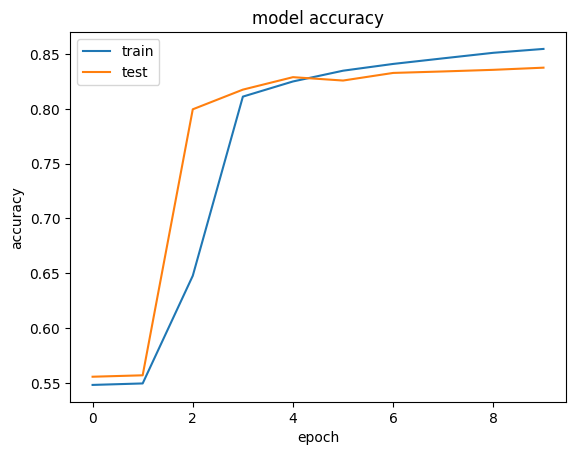

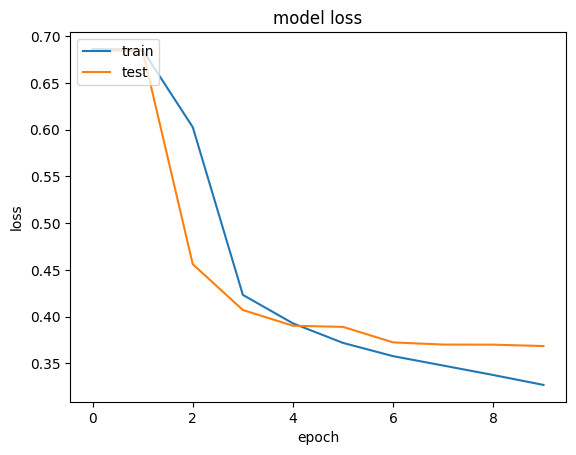

In [115]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Multi-lable Text Classification Model with Multiple Output Layers

In [84]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', str(sen))

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [85]:
X = []
sentences = list(df["cleaned"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = df[["hate_speech", "cyberbullying"]]

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [88]:
# First output
y1_train = y_train[["hate_speech"]].values
y1_test =  y_test[["hate_speech"]].values

# Second output
y2_train = y_train[["cyberbullying"]].values
y2_test =  y_test[["cyberbullying"]].values

In [89]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [90]:
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [91]:
input_1 = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer1 = LSTM(128)(embedding_layer)

output1 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output2 = Dense(1, activation='sigmoid')(LSTM_Layer1)

model = Model(inputs=input_1, outputs=[output1, output2])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [92]:
print(model.summary())


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 200, 100)     5222300     ['input_5[0][0]']                
                                                                                                  
 lstm_4 (LSTM)                  (None, 128)          117248      ['embedding_4[0][0]']            
                                                                                                  
 dense_4 (Dense)                (None, 1)            129         ['lstm_4[0][0]']                 
                                                                                            

In [93]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4b.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [94]:
history = model.fit(x=X_train, y=[y1_train, y2_train], batch_size=8192, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
8/8 [==============================] - 81s 10s/step - loss: 1.3796 - dense_4_loss: 0.6902 - dense_5_loss: 0.6894 - dense_4_acc: 0.5300 - dense_5_acc: 0.5482 - val_loss: 1.3704 - val_dense_4_loss: 0.6858 - val_dense_5_loss: 0.6846 - val_dense_4_acc: 0.5496 - val_dense_5_acc: 0.5562
Epoch 2/5
8/8 [==============================] - 73s 9s/step - loss: 1.5802 - dense_4_loss: 0.7875 - dense_5_loss: 0.7927 - dense_4_acc: 0.5387 - dense_5_acc: 0.5430 - val_loss: 1.3591 - val_dense_4_loss: 0.6801 - val_dense_5_loss: 0.6790 - val_dense_4_acc: 0.5630 - val_dense_5_acc: 0.5696
Epoch 3/5
8/8 [==============================] - 78s 10s/step - loss: 1.3700 - dense_4_loss: 0.6854 - dense_5_loss: 0.6845 - dense_4_acc: 0.5455 - dense_5_acc: 0.5513 - val_loss: 1.3718 - val_dense_4_loss: 0.6863 - val_dense_5_loss: 0.6854 - val_dense_4_acc: 0.5488 - val_dense_5_acc: 0.5554
Epoch 4/5
8/8 [==============================] - 75s 10s/step - loss: 1.3728 - dense_4_loss: 0.6868 - dense_5_loss: 0.6860 - 

In [95]:
score = model.evaluate(x=X_test, y=[y1_test, y2_test], verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

636/636 [==============================] - 19s 30ms/step - loss: 1.3726 - dense_4_loss: 0.6867 - dense_5_loss: 0.6859 - dense_4_acc: 0.5457 - dense_5_acc: 0.5513
Test Score: 1.3726214170455933
Test Accuracy: 0.6867104768753052


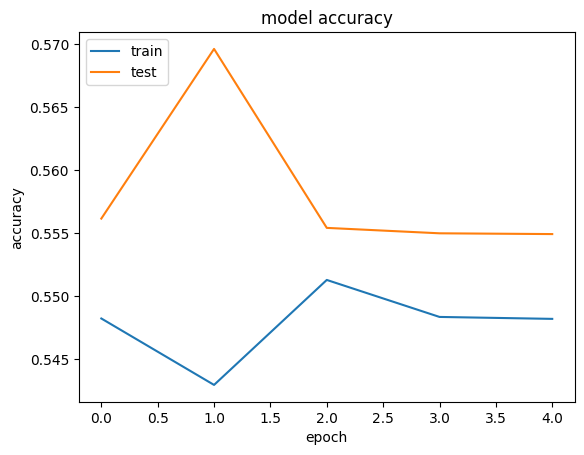

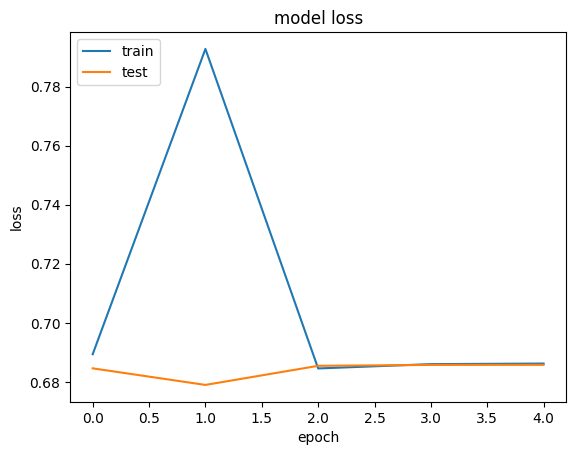

In [98]:
plt.plot(history.history['dense_5_acc'])
plt.plot(history.history['val_dense_5_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['dense_5_loss'])
plt.plot(history.history['val_dense_5_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()